<font size="5">Image classification – skin lesions</font>

<font size="4">Whether a skin lesion is benign or malign </font>

<font size="4">Importing Libraries</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import pandas as pd
import seaborn as sns
import os
import itertools
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow

import keras
from keras import backend
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, Callback, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, ResNet152V2, VGG16

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

<font size="4">Function to calculate Root Mean Squared Error (RMSE)</font>

In [2]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

<font size="4">Function to add more layers after the base pre-trained CNN to align the parameter numbers and outputs</font>

In [3]:
def add_cnn_layers(base_model, model):
    model.add(base_model)
    model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.40))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2, activation='softmax'))
    model.summary()
    return model

<font size="4">Function to calculate training + validation sets accuracy + loss + errors</font>

In [4]:
def train_val_accuracy(model, x_train_normalized, x_val_normalized, y_train, y_val):
    train_loss, train_accuracy, train_mse, train_mape, train_rmse = model.evaluate(x_train_normalized, y_train, verbose=1)
    val_loss, val_accuracy, val_mse, val_mape, val_rmse = model.evaluate(x_val_normalized, y_val, verbose=1)
    
    #Accuracy
    print("Training Accuracy:",train_accuracy*100,"%","")
    print("Validation Accuracy:",val_accuracy*100,"%","")

    #Loss
    print("\nTraining Loss:",train_loss)
    print("Validation Loss:",val_loss)

    #RMSE
    print("\nTraining RMSE:",train_rmse)
    print("Validation RMSE:",val_rmse)

    #MSE
    print("\nTraining MSE:",train_mse)
    print("Validation MSE:",val_mse)

    #MAPE
    print("\nTraining MAPE:",train_mape)
    print("Validation MAPE:",val_mape)

<font size="4">Function to calculate testing set accuracy + loss + errors</font>

In [5]:
def test_accuracy(model, x_test_normalized, y_test):
    test_loss, test_accuracy, test_mse, test_mape, test_rmse = model.evaluate(x_test_normalized, y_test, verbose=1)

<font size="4">Function to plot model accuracy + loss + errors against Epochs</font>

In [6]:
def plot_model_history(model_history, name):
    fig, axs = plt.subplots(2, 2, figsize=(15,15))
    
    #Summarize history for accuracy
    axs[0,0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0,0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0,0].set_title('Model Accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0,0].legend(['train', 'validation'], loc='best')
    
    #Summarize history for loss
    axs[0,1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[0,1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[0,1].set_title('Model Loss')
    axs[0,1].set_ylabel('Loss')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[0,1].legend(['train', 'validation'], loc='best')
    
    #Summarize history for RMSE
    axs[1,0].plot(range(1,len(model_history.history['rmse'])+1),model_history.history['rmse'])
    axs[1,0].plot(range(1,len(model_history.history['val_rmse'])+1),model_history.history['val_rmse'])
    axs[1,0].set_title('Model RMSE')
    axs[1,0].set_ylabel('RMSE')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_xticks(np.arange(1,len(model_history.history['rmse'])+1),len(model_history.history['rmse'])/10)
    axs[1,0].legend(['train', 'validation'], loc='best')
    
    #Summarize history for MSE
    axs[1,1].plot(range(1,len(model_history.history['mse'])+1),model_history.history['mse'])
    axs[1,1].plot(range(1,len(model_history.history['val_mse'])+1),model_history.history['val_mse'])
    axs[1,1].set_title('Model MSE')
    axs[1,1].set_ylabel('MSE')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_xticks(np.arange(1,len(model_history.history['mse'])+1),len(model_history.history['mse'])/10)
    axs[1,1].legend(['train', 'validation'], loc='best')
    
    #Plot and save figures
    plt.show()
    fig.savefig('../Photos/' + name + '_model_history.png', dpi=300)

<font size="4">Function to calculate true and predicted classes</font>

In [7]:
def cal_true_pred_classes(model, x_test_normalized, y_test):
    #Predicting the values from the testing set
    y_predict = model.predict(x_test_normalized)

    #Converting prediction classes to one hot vectors 
    y_predict_classes = np.argmax(y_predict, axis = 1) 

    #Converting testing label observations to one hot vectors
    y_true_classes = np.argmax(y_test, axis = 1) 
    
    return y_predict_classes, y_true_classes

<font size="4">Function to create testing set confusion matrix for true vs predicted labels</font>

In [8]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Getting the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Computing the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plotting the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

<font size="4">Function to print and plot the confusion matrix for true vs predicted labels</font>

In [9]:
def plot_confusion_matrix(cm, classes,
                          
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('name')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

<font size="4">Function to generate classification report</font>

In [10]:
def gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels):
    

    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
    
    report = classification_report(y_true_classes, y_predict_classes, target_names = cm_plot_labels)
    print(report)

<font size="4">Function to find out which category had the most accurate label classification %</font>

In [11]:
def plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, name):

    #Getting the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
        
    #Computing the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Calculation confusion matrix prediction error
    cm_prediction_error = (np.diag(confusion_matrix_computed) / np.sum(confusion_matrix_computed, axis=1))* 100

    #Bar plot
    plt.bar(np.arange(7), cm_prediction_error)

    #Plot title and labels
    plt.title(name)
    plt.xlabel('True Labels')
    plt.ylabel('Classified Labels %')

<font size="5">Creating a Dictionary of Images and their Labels</font>

<font size="4">Joining two paths together to form "../data</font>

In [12]:
base_skin_dir = os.path.join('..', 'C:/Users/Busra/AML/ham_data_surnamesVWXYZ/')

<font size="4">Retrieving image names from HAM10000 images folders & placing them in a dictionary</font>

In [13]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

<font size="5">4.Importing Dataset</font>


<font size="4">Reading dataset csv from the merged path of "../data/HAM10000_metadata.csv"</font>

In [14]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'C:/Users/Busra/AML/ham_data_surnamesVWXYZ/HAM10000_metadata.csv'))

<font size="5">5.Cleaning Dataset</font>

In [15]:
skin_df = skin_df.drop_duplicates(subset='image_id')
skin_df

,image_id,cell_type,is_benign,localization
0,ISIC_0025030,Benign keratosis-like lesions,1.0,scalp
1,ISIC_0025661,Benign keratosis-like lesions,1.0,scalp
2,ISIC_0027850,Benign keratosis-like lesions,1.0,ear
3,ISIC_0025837,Benign keratosis-like lesions,1.0,back
4,ISIC_0025209,Benign keratosis-like lesions,1.0,back
...,...,...,...,...
5364,ISIC_0025083,Melanoma,1.0,NaN
5365,ISIC_0031041,Melanocytic nevi,1.0,NaN
5366,ISIC_0028331,Melanocytic nevi,1.0,NaN
5367,ISIC_0026319,Melanoma,1.0,NaN


<font size="4">Check for missing values</font>

In [16]:
skin_df.isnull().sum()

image_id          0
cell_type       100
is_benign       100
localization     12
dtype: int64

In [17]:
skin_df.dropna(subset=['cell_type'], inplace=True)

<font size="4">Ensure there are no more missing values</font>

In [18]:
skin_df.isnull().sum()

image_id         0
cell_type        0
is_benign        0
localization    12
dtype: int64

<font size="4">6.Reading & Processing Dataset</font>

<font size="4">Adding new columns to the imported dataset for better readability & analysis</font>

In [19]:
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes 

<font size="4">View the first 5 entries of the dataframe</font>

<font size="4">Output descriptive statistics about the dataset's numeric types</font>

In [22]:
skin_df.describe()

,is_benign,cell_type_idx
count,5269.000000,5269.000000
mean,0.805846,3.626305
std,0.395586,1.207512
min,0.000000,0.000000
25%,1.000000,4.000000
50%,1.000000,4.000000
75%,1.000000,4.000000
max,1.000000,6.000000


<font size="5">7.Processing and Resizing Images</font>

In [23]:
im = Image.open(skin_df["path"][0])
width, height = im.size
print("Width: ", width)
print("Height:", height)

Width:  600
Height: 450


In [24]:
width/= 4
height/= 4
print("Width: ", width)
print("Height:", height)

Width:  150.0
Height: 112.5


In [25]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((int(width), int(height)))))

In [27]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(112, 150, 3)    5269
Name: image, dtype: int64

<font size="4">Image Sampling</font>

Text(0.5, 1.0, 'Actinic keratoses')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Basal cell carcinoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Benign keratosis-like lesions ')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Dermatofibroma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanocytic nevi')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Vascular lesions')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

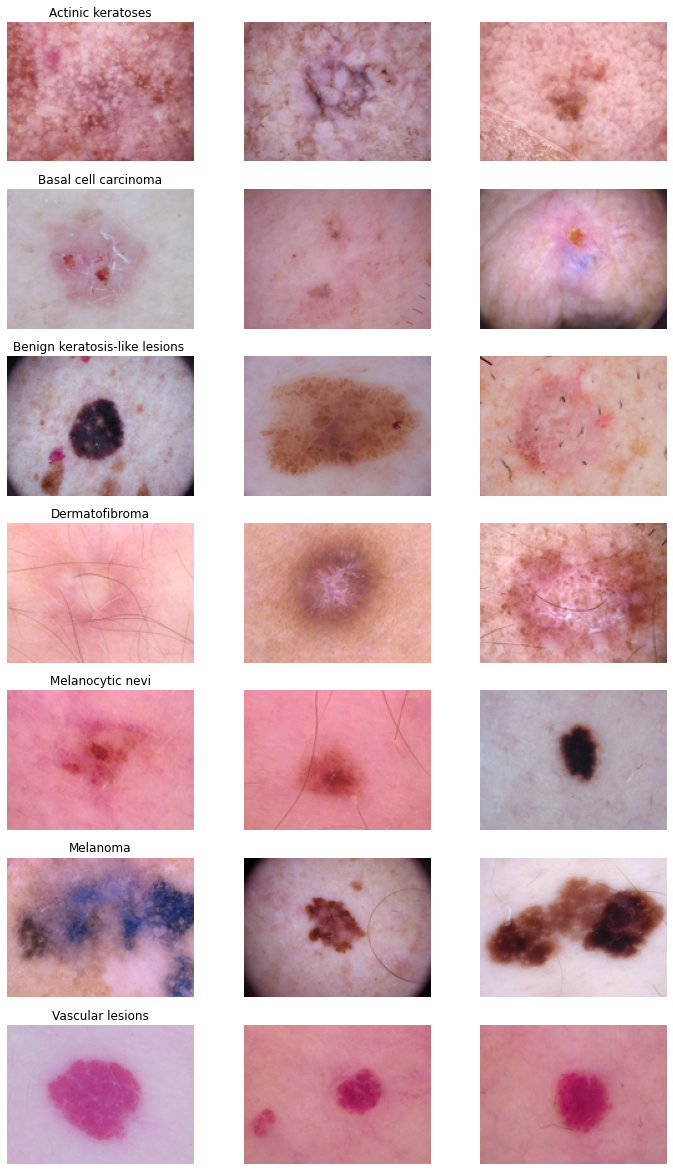

In [28]:
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

<font size="5">8.Features and Target Split</font>

In [156]:
features=skin_df.drop(columns=['is_benign'],axis=1)
target=skin_df['is_benign']

In [157]:
num_classes = 2
target_encoded = to_categorical(target, num_classes = num_classes)
print(target_encoded)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


<font size="5">9.Training, Validation, and Test Split</font>

<font size="4">80:20 Train Test Split</font>

In [158]:
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.20, stratify=target_encoded)

<font size="4">87.5:12.5 Train Validation Split from Initial Train Set</font>

In [159]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

<font size="5">10.Future Normalization</font>

<font size="4">Feature Normalization Converting the image values to a list</font>

In [160]:
x_train_images = np.asarray(X_train['image'].tolist())
x_val_images = np.asarray(X_val['image'].tolist())
x_test_images = np.asarray(X_test['image'].tolist())

<font size="4">Calculating train images' mean and standard deviation</font>

In [161]:
x_train_mean = np.mean(x_train_images)
x_train_std = np.std(x_train_images)

<font size="4">Normalization of each image by subtracting it's values from the training's mean value and then dividing by the training's standard deviation</font>

In [162]:
x_train_normalized = (x_train_images - x_train_mean)/x_train_std
x_val_normalized = (x_val_images - x_train_mean)/x_train_std
x_test_normalized = (x_test_images - x_train_mean)/x_train_std

<font size="4">Reshaping Images Reshape images back to their original width x height x depth values</font>

In [163]:
input_shape = (int(width), int(height), 3)
x_train_normalized = x_train_normalized.reshape(x_train_normalized.shape[0], * (input_shape))
x_val_normalized = x_val_normalized.reshape(x_val_normalized.shape[0], * (input_shape))
x_test_normalized = x_test_normalized.reshape(x_test_normalized.shape[0], * (input_shape))

<font size="5">11.Data Augmentation</font>

<font size="4">Data Augmentation Define and initialize augmented data properties</font>

In [164]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [165]:
augmented_data = ImageDataGenerator(featurewise_center=False, 
                                    samplewise_center=False, 
                                    featurewise_std_normalization=False, 
                                    samplewise_std_normalization=False, 
                                    zca_whitening=False, 
                                    zca_epsilon=1e-06, 
                                    rotation_range=20, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    brightness_range=None, 
                                    shear_range=0.1, 
                                    zoom_range=0.1, 
                                    channel_shift_range=0.1, 
                                    fill_mode='nearest', 
                                    cval=0.0, 
                                    horizontal_flip=False, 
                                    vertical_flip=False, 
                                    rescale=None, 
                                    preprocessing_function=None, 
                                    data_format='channels_last', 
                                    validation_split=0.0, 
                                    #interpolation_order=1, 
                                    #interpolation = 'bilinear',
                                    dtype='float32')

In [166]:
augmented_data.fit(x_train_normalized)

<font size="5">12.Basic Convolutional Neural Network (CNN) Implementation</font>

<font size="4">Creating the CNN Model</font>

In [167]:
#Keras Sequential API
#CNN Model: Conv x2 -> MaxPool -> Dropout -> Conv x2 -> MaxPool -> Dropout -> Flatten -> Dense -> Dropout -> Dense 
modelc = Sequential()
modelc.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same', input_shape=input_shape))
modelc.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
modelc.add(MaxPool2D(pool_size = (2, 2)))
modelc.add(Dropout(0.25))

modelc.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
modelc.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
modelc.add(MaxPool2D(pool_size=(2, 2)))
modelc.add(Dropout(0.40))

modelc.add(Flatten())
modelc.add(Dense(128, activation='relu'))
modelc.add(Dropout(0.5))
modelc.add(Dense(num_classes, activation='softmax'))
modelc.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 150, 112, 32)      896       
                                                                 
 conv2d_15 (Conv2D)          (None, 150, 112, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 75, 56, 32)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 75, 56, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 56, 64)        18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 75, 56, 64)        36928     
                                                      

<font size="4">Setting the optimizer</font>

In [168]:
optimizer = Adam(learning_rate=0.001)

<font size="4">Setting the loss function</font>

In [169]:
loss = "binary_crossentropy"

<font size="4">Setting the model metrics</font>

In [170]:
metrics=["accuracy", 'mse','mape', rmse]

<font size="4">Compiling the model</font>

In [171]:
modelc.compile(optimizer = optimizer , loss = loss, metrics = metrics)

<font size="4">Setting a learning rate reduction callback</font>

In [172]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [173]:
epochs = 25
batch_size = 20

In [174]:
historyc = modelc.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                epochs = 10, 
                                verbose = 1,
                                validation_data = (x_val_normalized, y_val),
                                callbacks = [reduce_lr])

Epoch 1/10


<ipython-input-174-bfacc4b01eb8>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  historyc = modelc.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),


169/169 [==============================] - 209s 1s/step - loss: 0.5369 - accuracy: 0.8028 - mse: 0.1666 - mape: 127895848.0000 - rmse: 0.2558 - val_loss: 0.4810 - val_accuracy: 0.8055 - val_mse: 0.1648 - val_mape: 119179832.0000 - val_rmse: 0.2384 - lr: 0.0010
Epoch 2/10
169/169 [==============================] - 209s 1s/step - loss: 0.4390 - accuracy: 0.8060 - mse: 0.1513 - mape: 120554792.0000 - rmse: 0.2411 - val_loss: 0.4458 - val_accuracy: 0.8055 - val_mse: 0.1399 - val_mape: 125585624.0000 - val_rmse: 0.2512 - lr: 0.0010
Epoch 3/10
169/169 [==============================] - 207s 1s/step - loss: 0.4164 - accuracy: 0.8060 - mse: 0.1434 - mape: 116872968.0000 - rmse: 0.2337 - val_loss: 0.4114 - val_accuracy: 0.8055 - val_mse: 0.1318 - val_mape: 119430760.0000 - val_rmse: 0.2389 - lr: 0.0010
Epoch 4/10
169/169 [==============================] - ETA: 0s - loss: 0.4078 - accuracy: 0.8060 - mse: 0.1408 - mape: 114651200.0000 - rmse: 0.2293
Epoch 4: ReduceLROnPlateau reducing learning ra

In [175]:
loading_dependencies = {'rmse': rmse}

In [176]:
model_name = "BasicCNN"

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Accuracy')

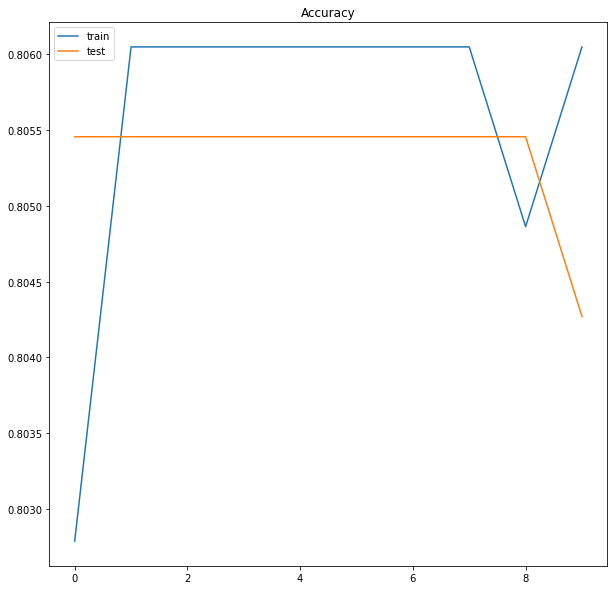

In [177]:
plt.figure(1, figsize=(10, 10))
plt.title('Accuracy')
plt.plot(historyc.history['accuracy'], label='train')
plt.plot(historyc.history['val_accuracy'], label='test')
plt.legend()
plt.show()

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Loss')

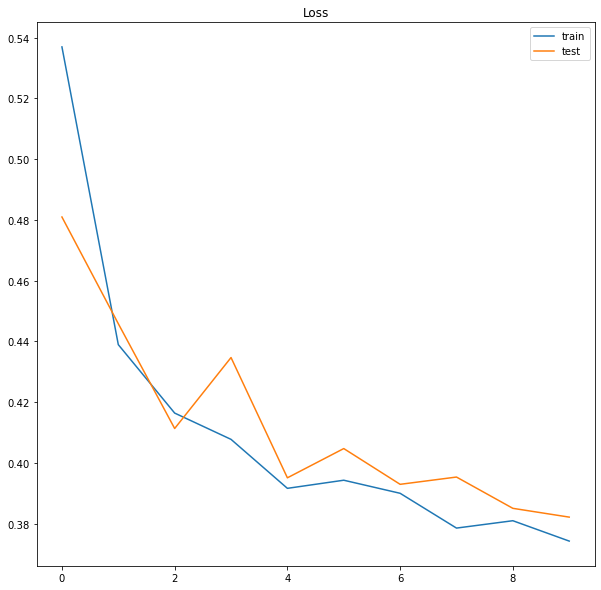

In [178]:
plt.figure(1, figsize=(10, 10))
plt.title('Loss')
plt.plot(historyc.history['loss'], label='train')
plt.plot(historyc.history['val_loss'], label='test')
plt.legend()
plt.show()

<font size="4">Basic CNN</font>

In [179]:
train_val_accuracy(modelc, x_train_normalized, x_val_normalized, y_train, y_val)

27/27 [==============================] - 11s 402ms/step - loss: 0.3822 - accuracy: 0.8043 - mse: 0.1331 - mape: 107487656.0000 - rmse: 0.2150
Training Accuracy: 80.87188601493835 % 
Validation Accuracy: 80.42704463005066 % 

Training Loss: 0.36335375905036926
Validation Loss: 0.3821913003921509

Training RMSE: 0.2072162628173828
Validation RMSE: 0.2149752825498581

Training MSE: 0.12911227345466614
Validation MSE: 0.1330847293138504

Training MAPE: 103608112.0
Validation MAPE: 107487656.0


<font size="4">ResNet152V2</font>

In [51]:
base_res_model = ResNet152V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, pooling=None, classes=1000)

In [52]:
res_model = Sequential()
res_model = add_cnn_layers(base_res_model, res_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 5, 4, 2048)        58331648  
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 4, 64)          1179712   
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 2, 2, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                      

In [53]:
res_model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

In [54]:
res_history = res_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                        epochs = 25, 
                                        verbose = 1,
                                        validation_data = (x_val_normalized, y_val),
                                        callbacks=[reduce_lr])

Epoch 1/25


<ipython-input-54-fbee3d25825b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  res_history = res_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),


169/169 [==============================] - 2089s 12s/step - loss: 0.6538 - accuracy: 0.7633 - mse: 0.1913 - mape: 127162664.0000 - rmse: 0.2543 - val_loss: 0.4899 - val_accuracy: 0.8055 - val_mse: 0.1793 - val_mape: 100313360.0000 - val_rmse: 0.2006 - lr: 1.0000e-05
Epoch 2/25
169/169 [==============================] - 1785s 11s/step - loss: 0.4816 - accuracy: 0.7909 - mse: 0.1614 - mape: 117155920.0000 - rmse: 0.2343 - val_loss: 0.4010 - val_accuracy: 0.8078 - val_mse: 0.1497 - val_mape: 102048912.0000 - val_rmse: 0.2041 - lr: 1.0000e-05
Epoch 3/25
169/169 [==============================] - 1765s 10s/step - loss: 0.4538 - accuracy: 0.7948 - mse: 0.1532 - mape: 114090168.0000 - rmse: 0.2282 - val_loss: 0.3840 - val_accuracy: 0.8066 - val_mse: 0.1425 - val_mape: 102994120.0000 - val_rmse: 0.2060 - lr: 1.0000e-05
Epoch 4/25
169/169 [==============================] - 1766s 10s/step - loss: 0.4296 - accuracy: 0.7983 - mse: 0.1462 - mape: 113766384.0000 - rmse: 0.2275 - val_loss: 0.3898 - v

In [55]:
res_model_name = "ResNet152V2"

In [56]:
train_val_accuracy(res_model, x_train_normalized, x_val_normalized, y_train, y_val)

27/27 [==============================] - 83s 3s/step - loss: 0.3556 - accuracy: 0.8446 - mse: 0.1188 - mape: 86057496.0000 - rmse: 0.1721
Training Accuracy: 85.37959456443787 % 
Validation Accuracy: 84.46025848388672 % 

Training Loss: 0.2884810268878937
Validation Loss: 0.3555540442466736

Training RMSE: 0.15718771517276764
Validation RMSE: 0.1721149981021881

Training MSE: 0.10532861202955246
Validation MSE: 0.11878127604722977

Training MAPE: 78593872.0
Validation MAPE: 86057496.0


<font size="5">Calculate Testing Set Accuracy + Loss + Errors</font>

<font size="4">Basic CNN</font>

In [180]:
test_accuracy(modelc, x_test_normalized, y_test)

33/33 [==============================] - 14s 410ms/step - loss: 0.3553 - accuracy: 0.8169 - mse: 0.1283 - mape: 101543392.0000 - rmse: 0.2031


<font size="4">ResNet152V2</font>

In [58]:
test_accuracy(res_model, x_test_normalized, y_test)

33/33 [==============================] - 105s 3s/step - loss: 0.3722 - accuracy: 0.8321 - mse: 0.1233 - mape: 87859096.0000 - rmse: 0.1757


<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Accuracy')

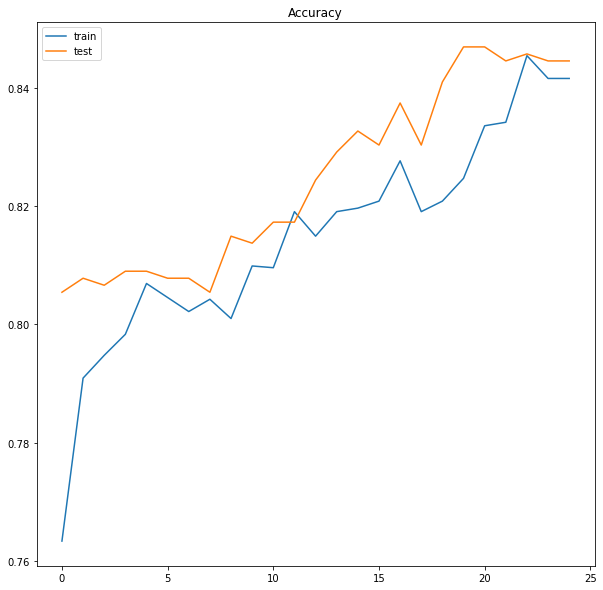

In [136]:
plt.figure(1, figsize=(10, 10))
plt.title('Accuracy')
plt.plot(res_history.history['accuracy'], label='train')
plt.plot(res_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Loss')

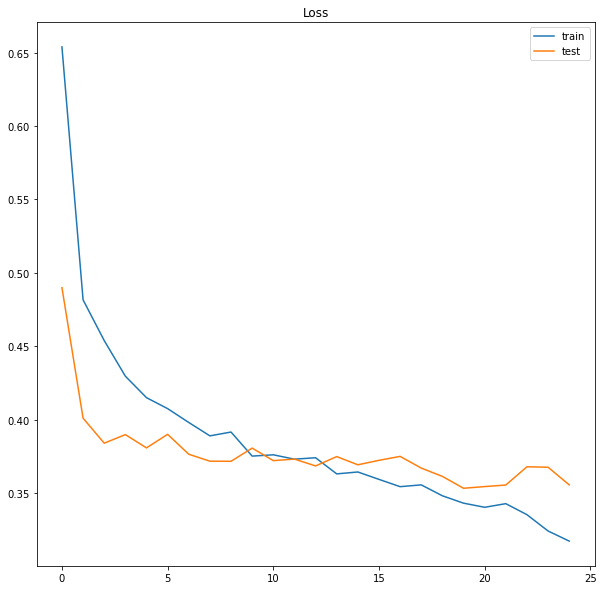

In [138]:
plt.figure(1, figsize=(10, 10))
plt.title('Loss')
plt.plot(res_history.history['loss'], label='train')
plt.plot(res_history.history['val_loss'], label='test')
plt.legend()
plt.show()

<font size="5">Testing Set Confusion Matrix for True vs Predicted Labels</font>

<font size="4">Basic CNN</font>

In [181]:
#listing the class names
class_names=['benign', 'malignant']

Confusion matrix, without normalization
[[ 17 188]
 [  5 844]]


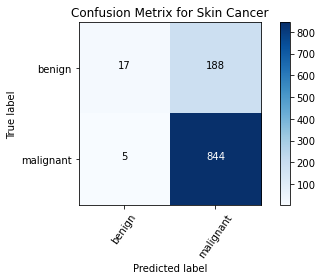

In [182]:
from sklearn.metrics import confusion_matrix

y_pred = modelc.predict(x_test_normalized)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_labels =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_labels, title ='Confusion Metrix for Skin Cancer')

Normalized confusion matrix
[[0.08292683 0.91707317]
 [0.00588928 0.99411072]]


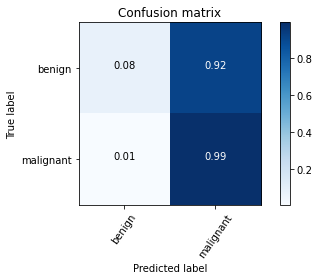

In [183]:
create_confusion_matrix(modelc, x_test_normalized, y_test, cm_plot_labels, model_name)

<font size="4">ResNet152V2</font>

Normalized confusion matrix
[[0.28780488 0.71219512]
 [0.03651355 0.96348645]]


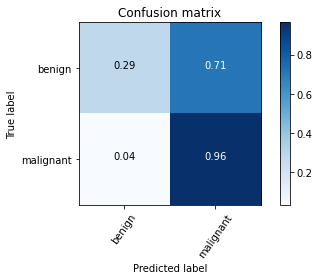

In [61]:
create_confusion_matrix(res_model, x_test_normalized, y_test, cm_plot_labels, res_model_name)

<font size="5">Calculate Testing Set Accuracy + Loss + Errors</font>

<font size="4">Basic CNN</font>

In [184]:
test_accuracy(modelc, x_test_normalized, y_test)

33/33 [==============================] - 13s 407ms/step - loss: 0.3553 - accuracy: 0.8169 - mse: 0.1283 - mape: 101543392.0000 - rmse: 0.2031


<font size="4">ResNet152V2</font>

In [63]:
test_accuracy(res_model, x_test_normalized, y_test)

33/33 [==============================] - 104s 3s/step - loss: 0.3722 - accuracy: 0.8321 - mse: 0.1233 - mape: 87859096.0000 - rmse: 0.1757


Text(0.5, 1.0, 'Training and validation accuracy')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

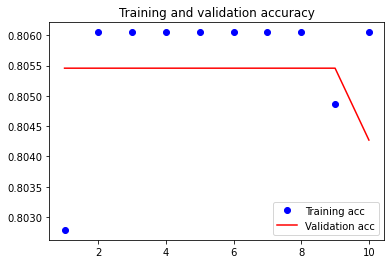

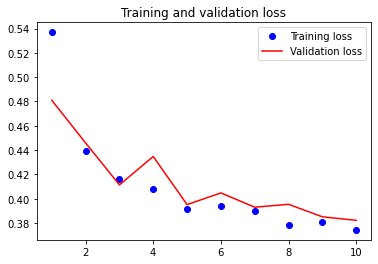

In [185]:
acc = historyc.history['accuracy']
val_acc = historyc.history['val_accuracy']
loss = historyc.history['loss']
val_loss = historyc.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<font size="5">Generate a Confusion Matrix Classification Report</font>

<font size="5">Basic CNN</font>

In [65]:
gen_classification_report(model, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       205
   malignant       0.81      1.00      0.89       849

    accuracy                           0.80      1054
   macro avg       0.40      0.50      0.45      1054
weighted avg       0.65      0.80      0.72      1054



<font size="4">ResNet152V2</font>

In [66]:
gen_classification_report(res_model, x_test_normalized, y_test, cm_plot_labels)

              precision    recall  f1-score   support

      benign       0.66      0.29      0.40       205
   malignant       0.85      0.96      0.90       849

    accuracy                           0.83      1054
   macro avg       0.75      0.63      0.65      1054
weighted avg       0.81      0.83      0.80      1054



<font size="5">Find Out Which Skin Lesion Category had the Most Accurate Label Classification</font>

<font size="4">Basic CNN</font>

In [67]:
def plot_label_classification_acc(model, x_test_normalized, y_test, cm_plot_labels, name):

    #Getting the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)
        
    #Computing the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Calculation confusion matrix prediction error
    cm_prediction_error = (np.diag(confusion_matrix_computed) / np.sum(confusion_matrix_computed, axis=1))* 100

    #Bar plot
    plt.bar([0,1], cm_prediction_error)

    #Plot title and labels
    plt.title(name)
    plt.xlabel('True Labels')
    plt.ylabel('Classified Labels %')

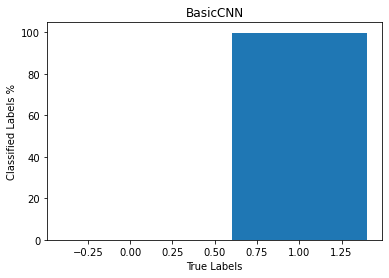

In [68]:
plot_label_classification_acc(modelc, x_test_normalized, y_test, cm_plot_labels, model_name)

<font size="5">The fine-grained diagnosis for the skin lesion for 7 categories</font>

<font size="4">Function to add more layers after the base pre-trained CNN to align the parameter numbers and outputs</font>

In [70]:
def add_cnn_layers(base_model, modelc):
    model.add(base_model)
    model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.40))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation='softmax'))
    model.summary()
    return model

<font size="4">Diagnostic skin lesion categories dictionary</font>

In [71]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

<font size="5">Exploratory Data Analysis (EDA)</font>

<font size="4">Visualize the distributions of the 7 different skin lesion categories</font>

<Figure size 864x288 with 0 Axes>

<AxesSubplot:>

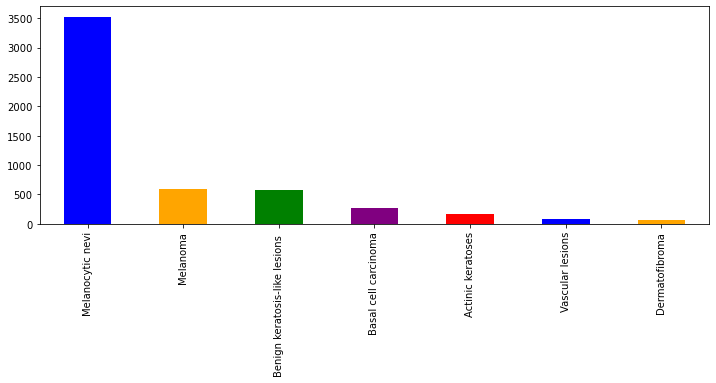

In [72]:
plt.figure(figsize=(12, 4))
skin_df['cell_type'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red"])

In [73]:
skin_df['cell_type'].value_counts()

Melanocytic nevi                  3525
Melanoma                           587
Benign keratosis-like lesions      579
Basal cell carcinoma               275
Actinic keratoses                  167
Vascular lesions                    77
Dermatofibroma                      59
Name: cell_type, dtype: int64

<font size="4">Visualize the distributions of the different localizations</font>

<Figure size 864x288 with 0 Axes>

<AxesSubplot:>

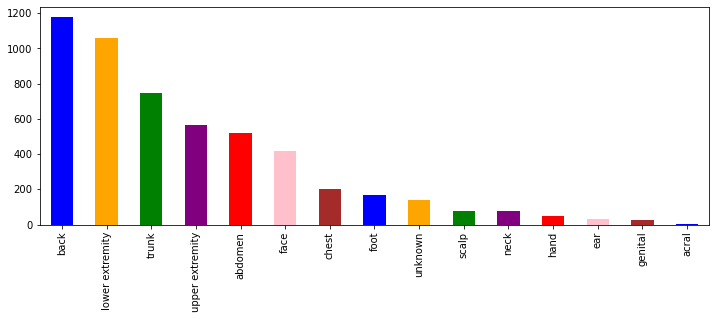

In [74]:
plt.figure(figsize=(12, 4))
skin_df['localization'].value_counts().plot(kind='bar', color=["blue", "orange", "green", "purple", "red", "pink", "brown"])

<Figure size 864x288 with 0 Axes>

<AxesSubplot:>

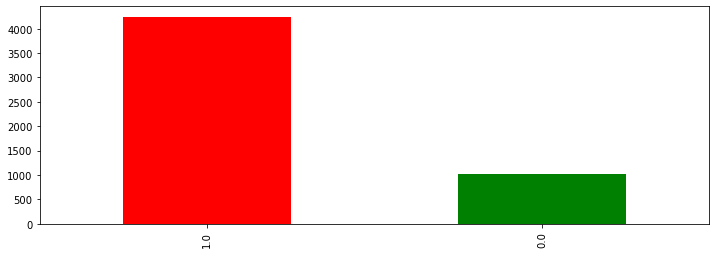

In [75]:
plt.figure(figsize=(12, 4))
skin_df['is_benign'].value_counts().plot(kind='bar', color=["red", "green"])

In [76]:
skin_df['is_benign'].value_counts()

1.0    4246
0.0    1023
Name: is_benign, dtype: int64

<font size="4">Image Sampling</font>

Text(0.5, 1.0, 'Actinic keratoses')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Basal cell carcinoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Benign keratosis-like lesions ')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Dermatofibroma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanocytic nevi')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Melanoma')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

Text(0.5, 1.0, 'Vascular lesions')

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

(-0.5, 149.5, 111.5, -0.5)

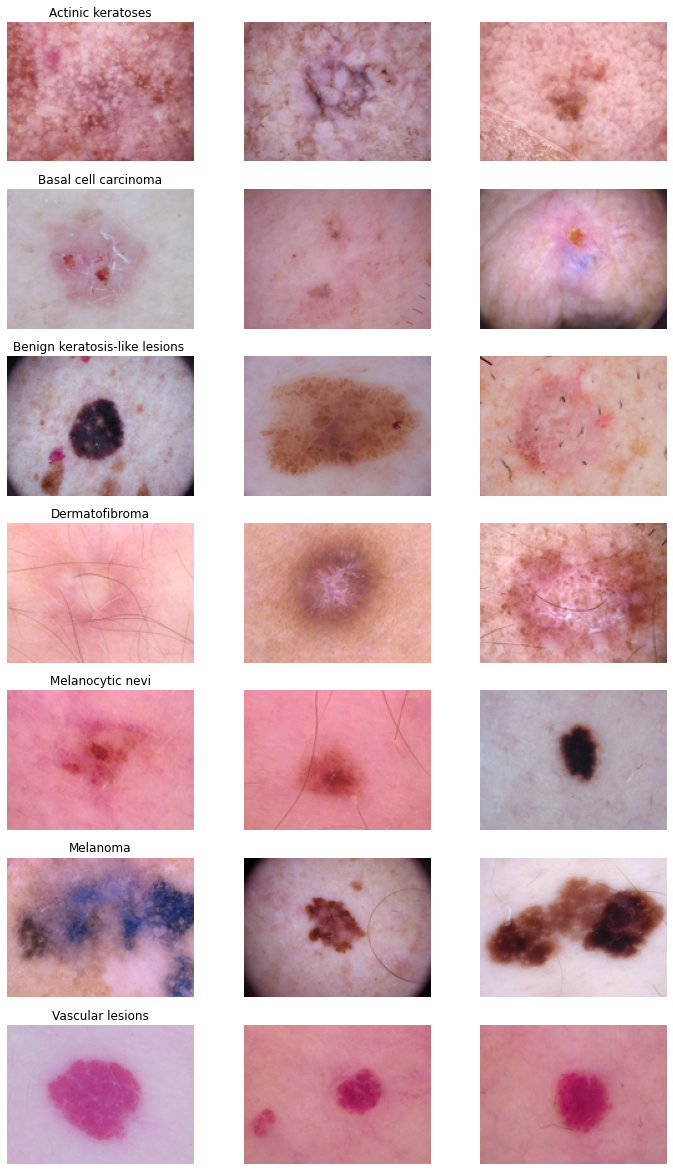

In [77]:
n_samples = 3
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

<font size="5">Features and Target Split</font>

<font size="4">Target: Diagnostic skin lesion category</font>

In [78]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

<font size="4"> Target One-Hot Encoding</font>

In [79]:
num_classes = 7
target_encoded = to_categorical(target, num_classes = num_classes)
print(target_encoded)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


<font size="4">Training, Validation, and Test Split</font>

<font size="4">80:20 Train Test Split</font>

In [80]:
X_train, X_test, y_train, y_test = train_test_split(features, target_encoded, test_size=0.20, stratify=target_encoded)

<font size="4">87.5:12.5 Train Validation Split from Initial Train Set</font>

In [81]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

<font size="5">Basic Convolutional Neural Network (CNN) Implementation</font>

<font size="4">Creating the CNN Model</font>

In [82]:
#CNN Model: Conv x2 -> MaxPool -> Dropout -> Conv x2 -> MaxPool -> Dropout -> Flatten -> Dense -> Dropout -> Dense 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 112, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 150, 112, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 75, 56, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 56, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 56, 64)        36928     
                                                      

<font size="5">Setting the optimizer</font>

In [83]:
optimizer = Adam(learning_rate=0.001)

<font size="4">Setting the loss function</font>

In [84]:
loss = "categorical_crossentropy"

<font size="4">Setting the model metrics</font>

In [85]:
metrics=["accuracy", 'mse', 'mape', rmse]

<font size="4">Compiling the model</font>

In [86]:
model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

<font size="4">Setting a learning rate reduction callback</font>

In [87]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [88]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # nv # Try to make the model more sensitive to Melanocytic nevi
    5: 1.0, # mel
    6: 1.0, # vasc
}

In [89]:
epochs = 25
batch_size = 20
#steps_per_epoch = len(x_train_normalized) / 10

In [90]:
history = model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                epochs = 25, 
                                verbose = 1,
                                class_weight = class_weights,
                                validation_data = (x_val_normalized, y_val), 
                                #steps_per_epoch = steps_per_epoch,
                                callbacks = [reduce_lr])

<ipython-input-90-fa34bba8cbc0>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),


Epoch 1/25
169/169 [==============================] - 203s 1s/step - loss: 1.9438 - accuracy: 0.6637 - mse: 0.0832 - mape: 64137152.0000 - rmse: 0.2145 - val_loss: 1.1977 - val_accuracy: 0.6690 - val_mse: 0.0787 - val_mape: 63466960.0000 - val_rmse: 0.2112 - lr: 0.0010
Epoch 2/25
169/169 [==============================] - 202s 1s/step - loss: 1.5704 - accuracy: 0.6690 - mse: 0.0811 - mape: 61369788.0000 - rmse: 0.2071 - val_loss: 1.3093 - val_accuracy: 0.6690 - val_mse: 0.0837 - val_mape: 56563028.0000 - val_rmse: 0.1966 - lr: 0.0010
Epoch 3/25
169/169 [==============================] - 200s 1s/step - loss: 1.5622 - accuracy: 0.6690 - mse: 0.0816 - mape: 61297436.0000 - rmse: 0.2071 - val_loss: 1.2951 - val_accuracy: 0.6690 - val_mse: 0.0832 - val_mape: 57159652.0000 - val_rmse: 0.1980 - lr: 0.0010
Epoch 4/25
169/169 [==============================] - ETA: 0s - loss: 1.5414 - accuracy: 0.6690 - mse: 0.0814 - mape: 60799356.0000 - rmse: 0.2057
Epoch 4: ReduceLROnPlateau reducing learnin

In [91]:
loading_dependencies = {
     'rmse': rmse
}

<font size="4">Setting the base model to VGG16</font>

In [92]:
base_vgg_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet', input_tensor=None, pooling=None, classes=1000)

In [93]:
vgg_model = Sequential()
vgg_model = add_cnn_layers(base_vgg_model, vgg_model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 3, 512)         14714688  
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 3, 64)          294976    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 1, 64)         0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 2, 1, 64)          0         
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                      

<font size="4">Compiling the model</font>

In [94]:
vgg_model.compile(optimizer = optimizer , loss = loss, metrics = metrics)

<font size="4">Fit the model on batches with real-time data augmentation</font>

In [95]:
vgg_history = vgg_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                        epochs = 25, 
                                        verbose = 1,
                                        class_weight = class_weights,
                                        validation_data = (x_val_normalized, y_val), 
                                        #steps_per_epoch = steps_per_epoch,
                                        callbacks=[reduce_lr])

<ipython-input-95-a008a25ec75e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg_history = vgg_model.fit_generator(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),


Epoch 1/25
169/169 [==============================] - 1407s 8s/step - loss: 2.0242 - accuracy: 0.6352 - mse: 0.0869 - mape: 69998048.0000 - rmse: 0.2290 - val_loss: 1.2584 - val_accuracy: 0.6690 - val_mse: 0.0807 - val_mape: 61125112.0000 - val_rmse: 0.2049 - lr: 1.0000e-05
Epoch 2/25
169/169 [==============================] - 1378s 8s/step - loss: 1.7606 - accuracy: 0.6655 - mse: 0.0828 - mape: 64790392.0000 - rmse: 0.2149 - val_loss: 1.2273 - val_accuracy: 0.6690 - val_mse: 0.0792 - val_mape: 63612728.0000 - val_rmse: 0.2099 - lr: 1.0000e-05
Epoch 3/25
169/169 [==============================] - 1419s 8s/step - loss: 1.7372 - accuracy: 0.6661 - mse: 0.0828 - mape: 64156884.0000 - rmse: 0.2134 - val_loss: 1.2175 - val_accuracy: 0.6690 - val_mse: 0.0794 - val_mape: 62710164.0000 - val_rmse: 0.2084 - lr: 1.0000e-05
Epoch 4/25
169/169 [==============================] - 1354s 8s/step - loss: 1.7035 - accuracy: 0.6687 - mse: 0.0824 - mape: 64107128.0000 - rmse: 0.2132 - val_loss: 1.2776 - v

<font size="4">Fit the model on batches with real-time data augmentation</font>

<font size="5">Calculate Training and Validation Sets Accuracy + Loss + Errors</font>

<font size="4">Basic CNN</font>

In [96]:
train_val_accuracy(model, x_train_normalized, x_val_normalized, y_train, y_val)

27/27 [==============================] - 11s 403ms/step - loss: 1.2712 - accuracy: 0.6690 - mse: 0.0819 - mape: 58440756.0000 - rmse: 0.2006
Training Accuracy: 66.90391302108765 % 
Validation Accuracy: 66.90391302108765 % 

Training Loss: 1.2568837404251099
Validation Loss: 1.2712434530258179

Training RMSE: 0.20002181828022003
Validation RMSE: 0.20062080025672913

Training MSE: 0.0815286710858345
Validation MSE: 0.0819397047162056

Training MAPE: 58321900.0
Validation MAPE: 58440756.0


<font size="4">VGG16</font>

In [97]:
train_val_accuracy(vgg_model, x_train_normalized, x_val_normalized, y_train, y_val)

27/27 [==============================] - 84s 3s/step - loss: 1.2163 - accuracy: 0.6690 - mse: 0.0799 - mape: 61850996.0000 - rmse: 0.2071
Training Accuracy: 66.90391302108765 % 
Validation Accuracy: 66.90391302108765 % 

Training Loss: 1.2055160999298096
Validation Loss: 1.2162631750106812

Training RMSE: 0.2057301551103592
Validation RMSE: 0.20712429285049438

Training MSE: 0.07923034578561783
Validation MSE: 0.07986251264810562

Training MAPE: 61455816.0
Validation MAPE: 61850996.0


<font size="5">Calculate Testing Set Accuracy + Loss + Errors</font>

<font size="4">Basic CNN</font>

In [99]:
test_accuracy(model, x_test_normalized, y_test)

33/33 [==============================] - 14s 416ms/step - loss: 1.2716 - accuracy: 0.6689 - mse: 0.0820 - mape: 58675320.0000 - rmse: 0.2013


<font size="4">VGG16</font>

In [100]:
test_accuracy(vgg_model, x_test_normalized, y_test)

33/33 [==============================] - 109s 3s/step - loss: 1.2170 - accuracy: 0.6689 - mse: 0.0798 - mape: 61759320.0000 - rmse: 0.2068


<font size="5">Testing Set Confusion Matrix for True vs Predicted Labels</font>

In [101]:
#Define the labels of the class indices. These need to match the order shown above.
cm_plot_labels=['akiec', 'bcc', 'bkl', 'df', 'nv','mel', 'vasc']

<font size="4">Basic CNN</font>

Confusion matrix, without normalization
[[  0   0   0   0  33   0   0]
 [  0   0   0   0  55   0   0]
 [  0   0   0   0 116   0   0]
 [  0   0   0   0  12   0   0]
 [  0   0   0   0 705   0   0]
 [  0   0   0   0 118   0   0]
 [  0   0   0   0  15   0   0]]


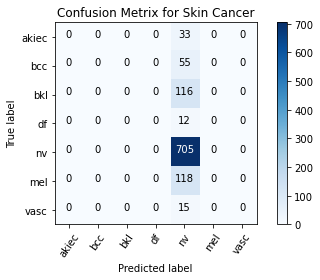

In [139]:
from sklearn.metrics import confusion_matrix

y_pred = vgg_model.predict(x_test_normalized)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

cm_plot_label =['akiec', 'bcc', 'bkl', 'df', 'nv','mel', 'vasc']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Normalized confusion matrix
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


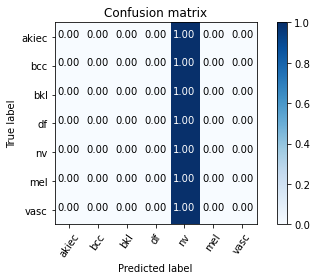

In [140]:
create_confusion_matrix(vgg_model, x_test_normalized, y_test, cm_plot_label, model_name)

<font size="4">VGG16</font>

In [110]:
vgg_model_name = 'VGG16'

<font size="5">Generate a Confusion Matrix Classification Report</font>

<font size="4">Basic CNN</font>

In [117]:
gen_classification_report(model, x_test_normalized, y_test, cm_plot_label)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        55
         bkl       0.00      0.00      0.00       116
          df       0.00      0.00      0.00        12
          nv       0.67      1.00      0.80       705
         mel       0.00      0.00      0.00       118
        vasc       0.00      0.00      0.00        15

    accuracy                           0.67      1054
   macro avg       0.10      0.14      0.11      1054
weighted avg       0.45      0.67      0.54      1054



C:\Users\zaid_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zaid_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zaid_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<font size="4">VGG16</font>

In [118]:
gen_classification_report(vgg_model, x_test_normalized, y_test, cm_plot_label)

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        33
         bcc       0.00      0.00      0.00        55
         bkl       0.00      0.00      0.00       116
          df       0.00      0.00      0.00        12
          nv       0.67      1.00      0.80       705
         mel       0.00      0.00      0.00       118
        vasc       0.00      0.00      0.00        15

    accuracy                           0.67      1054
   macro avg       0.10      0.14      0.11      1054
weighted avg       0.45      0.67      0.54      1054



C:\Users\zaid_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zaid_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zaid_\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Basic CNN

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Accuracy')

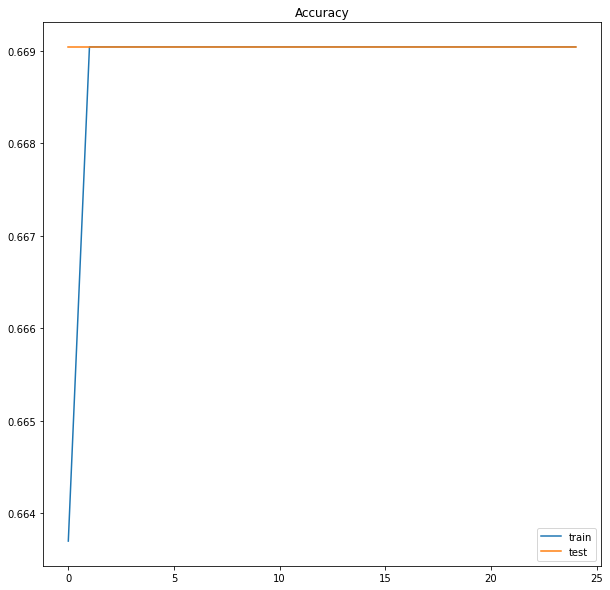

In [130]:
plt.figure(1, figsize=(10, 10))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Loss')

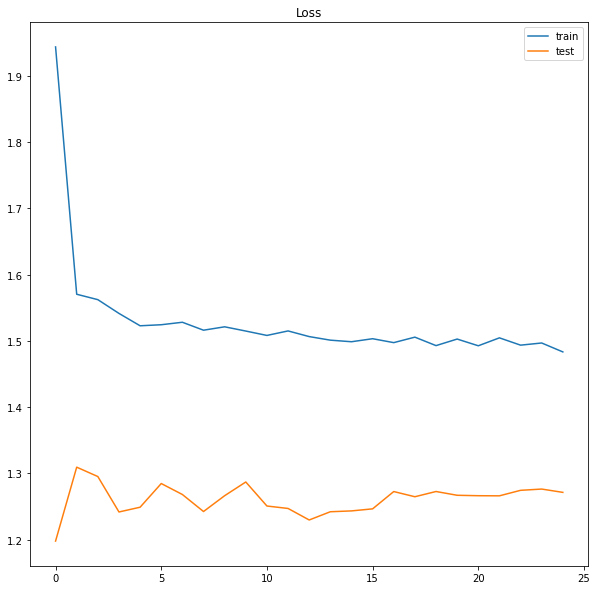

In [131]:
plt.figure(1, figsize=(10, 10))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

VGG CNN

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Loss')

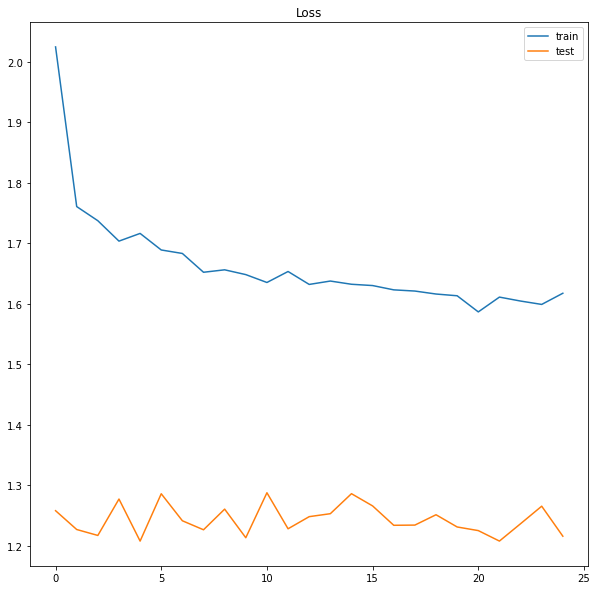

In [132]:
plt.figure(1, figsize=(10, 10))
plt.title('Loss')
plt.plot(vgg_history.history['loss'], label='train')
plt.plot(vgg_history.history['val_loss'], label='test')
plt.legend()
plt.show()

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Accuracy')

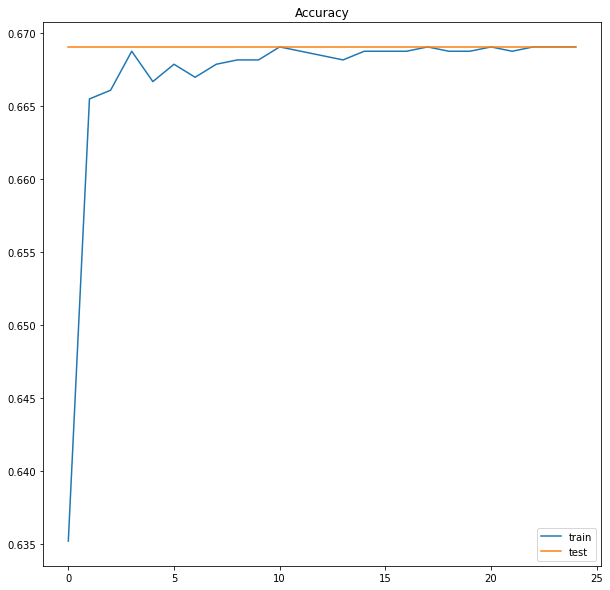

In [133]:
plt.figure(1, figsize=(10, 10))
plt.title('Accuracy')
plt.plot(vgg_history.history['accuracy'], label='train')
plt.plot(vgg_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [142]:
vgg_history2 = vgg_model.fit(augmented_data.flow(x_train_normalized, y_train, batch_size = batch_size),
                                        epochs = 1, 
                                        #verbose = 1,
                                        class_weight = class_weights,
                                        validation_data = (x_val_normalized, y_val), 
                                        #steps_per_epoch = steps_per_epoch,
                                        callbacks=[reduce_lr])

169/169 [==============================] - 1445s 9s/step - loss: 1.5990 - accuracy: 0.6690 - mse: 0.0819 - mape: 61959720.0000 - rmse: 0.2085 - val_loss: 1.2696 - val_accuracy: 0.6690 - val_mse: 0.0822 - val_mape: 58631168.0000 - val_rmse: 0.2005 - lr: 1.0000e-05
